# A Business Analysis of Sales Data.


Howdy folks and welcome to my little business analysis project. Credit for this goes entirely to Keith Galli for providing both the data as well as a walkthrough tutorial for beginners to follow along with.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  

In [105]:
sns.set(rc={'figure.figsize':(18.7,5.27)})

In this notebook, we analyse sales data and answer a few business questions:

- What was the best month for sales? How much was earned that month?
- What city sold the most product?
- What time should we display advertisemens to maximize the likelihood of customer’s buying product?
- What products are most often sold together?
- What product sold the most? Why do you think it sold the most?


### Task 1: Find a way to merge the sales files into one csv. Also drop all NA values.

What we have with us is the sales data for each month in the year 2019. For our analysis, it would be pertinent to merge all these files into one csv. Along the way, I'll also be cleaning the files up a bit for convenience.

In [145]:
import os

def merge_process_multiple(dirpath, destination):
    files = os.listdir(dirpath)
    df = pd.DataFrame()
    for file in files:
        df_1 = pd.read_csv(dirpath + file)
        df = pd.concat([df, df_1])
    df.dropna(inplace=True)
    df.to_csv(destination, index=False)
        
merge_process_multiple('./salesfiles/Sales_Data/', './salesfiles_merged/sales_merged.csv')

### Task 2: Import the newly generated csv file.

In [108]:
sales = pd.read_csv('./salesfiles_merged/sales_merged.csv')

### Task 3: Create a column for month so that we can tackle the first question.

Now a couple of issues will arise when we generate a column for the month to which each sale belongs to.

When we first extract the months from the values in Order Date, we find that we are actually extracting strings. So we'll have to convert those to integer types.

We also find that some values in the Month column is the string 'Or', and so we have to delete all the rows that have 'Or' as a value.

In [109]:
sales['Month'] = sales['Order Date'].str[0:2]

sales = sales[sales['Month'] != 'Or']

sales['Month'] = sales['Month'].astype('int32')

month_net_sales = sales.groupby('Month').sum()
month_net_sales.reset_index(inplace=True)

### Task 4: Add a column for sales.

We convert the values of type String in Quantity Ordered and Price Each to numeric values.

In [117]:
sales['Quantity Ordered'] = pd.to_numeric(sales['Quantity Ordered'])
sales['Price Each'] = pd.to_numeric(sales['Price Each'])

In [123]:
sales['Sales'] = sales['Quantity Ordered'] * sales['Price Each']

### Task 5: Extract the name of the city (and state) from the Purchase Address column.

In [ ]:
x = sales['Purchase Address'].str.split(', ').apply(lambda x: x[1])

y = sales['Purchase Address'].str.split(',').apply(lambda x: x[2]).str[0:3]

sales['City'] = x + y

In [126]:
city_sales = sales.groupby('City').sum()
city_sales.reset_index(inplace = True)

### Task 6: Extract relevant daily time information from Order Date.

In [127]:
sales['Order Date'] = pd.to_datetime(sales['Order Date'])

sales['Hour'] = sales['Order Date'].dt.hour


hour_sales = sales.groupby('Hour').sum()
hour_sales.reset_index(inplace=True)

## Question 1: What was the best month for sales? How much was earned that month?

In [134]:
month_net_sales = month_net_sales[['Month', 'Sales']]

Text(0.5, 1.0, 'Net Monthly Sales')

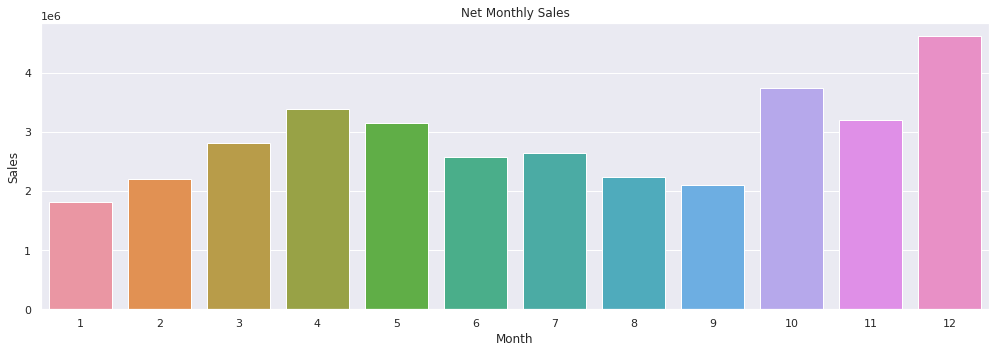

In [158]:
g = sns.barplot(data=month_net_sales, x='Month', y='Sales', estimator=sum)
plt.title('Net Monthly Sales')

## Question 2: What city had the most sales?

Text(0.5, 1.0, 'Net Sales per City')

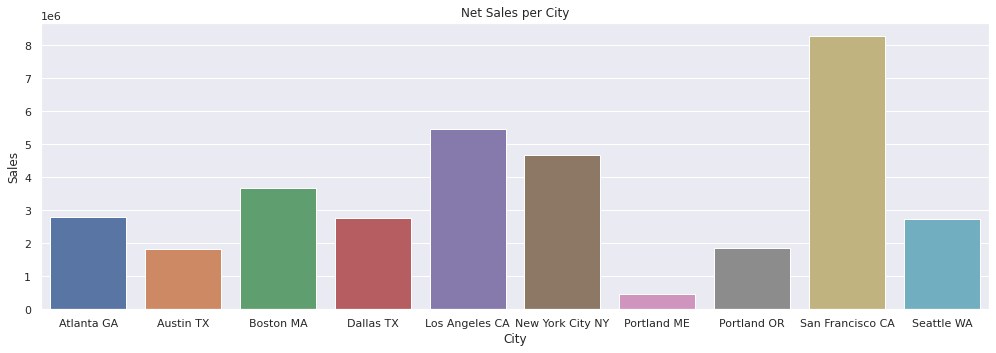

In [185]:
g = sns.barplot(data=city_sales, x='City', y='Sales')
plt.title('Net Sales per City')

## Question 3: What hour of the day sees the most sales? Should we advertise products during these hours to maximise the possibility of a customer purchasing an item?

Text(0.5, 1.0, 'Which hour of the day has seen them most sales?')

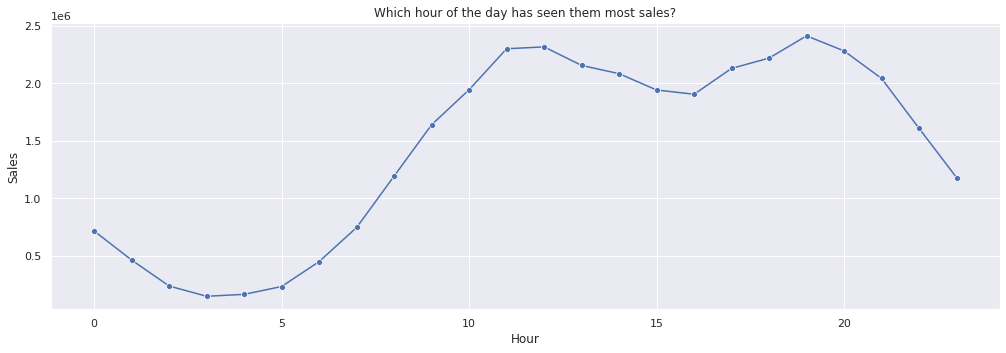

In [164]:
g = sns.lineplot(data=hour_sales, x='Hour', y='Sales', marker="o")
plt.title('Which hour of the day has seen them most sales?')

## Question 4: Which product sells the most and why is it so?

In [143]:
product_sales = sales.groupby('Product').sum().drop(columns=['Price Each', 'Sales', 'Hour'])
product_sales.reset_index(inplace=True)

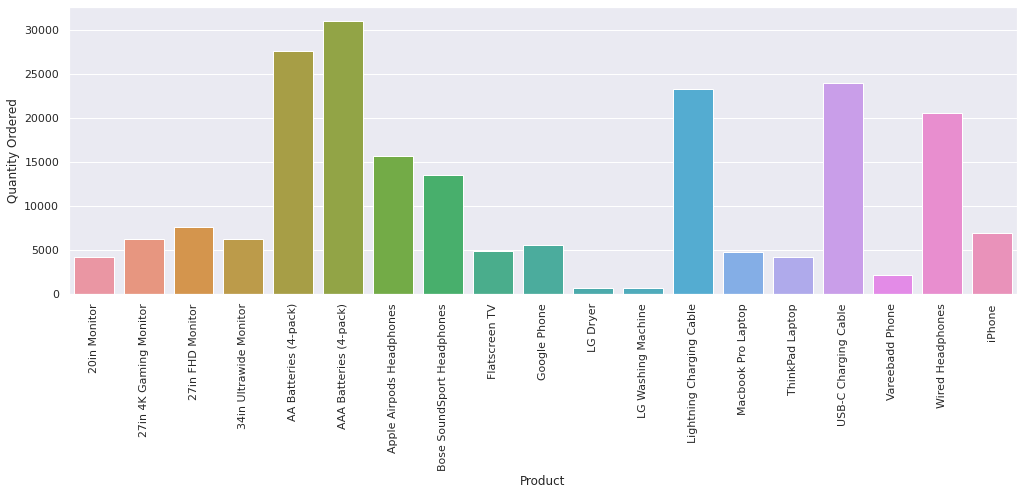

In [182]:
sns.set(rc={'figure.figsize':(17,5.27)})
g = sns.barplot(data=product_sales, x='Product', y='Quantity Ordered')
a = plt.xticks(rotation=90) 

### Question 5: Which products are most often sold together?

A set of items are sold together if they have the same Order ID.

In [140]:
df = sales[sales['Order ID'].duplicated(keep=False)]

df['Groups'] = df.groupby('Order ID')['Product'].transform(lambda x: ','.join(x))

df = df[['Order ID', 'Groups']].drop_duplicates()

df

,Order ID,Groups
20,248171,"USB-C Charging Cable,USB-C Charging Cable"
60,248210,"iPhone,Lightning Charging Cable"
70,248219,"Bose SoundSport Headphones,Google Phone"
117,248265,"Vareebadd Phone,Bose SoundSport Headphones"
176,248323,"Google Phone,Bose SoundSport Headphones"
...,...,...
186155,209778,"iPhone,Apple Airpods Headphones"
186163,209785,"Flatscreen TV,AA Batteries (4-pack)"
186173,209794,"USB-C Charging Cable,Wired Headphones"
186191,209810,"AA Batteries (4-pack),USB-C Charging Cable"


In [180]:
from itertools import combinations
from collections import Counter

count = Counter()

for value in df['Groups']:
    row_list = value.split(',')
    count.update(Counter(combinations(row_list, 2)))
    
    
x = count.most_common(10)
pd.DataFrame(x)

,0,1
0,"(iPhone, Lightning Charging Cable)",1005
1,"(Google Phone, USB-C Charging Cable)",987
2,"(iPhone, Wired Headphones)",447
3,"(Google Phone, Wired Headphones)",414
4,"(Vareebadd Phone, USB-C Charging Cable)",361
5,"(iPhone, Apple Airpods Headphones)",360
6,"(Google Phone, Bose SoundSport Headphones)",220
7,"(USB-C Charging Cable, Wired Headphones)",160
8,"(Vareebadd Phone, Wired Headphones)",143
9,"(Lightning Charging Cable, Wired Headphones)",92


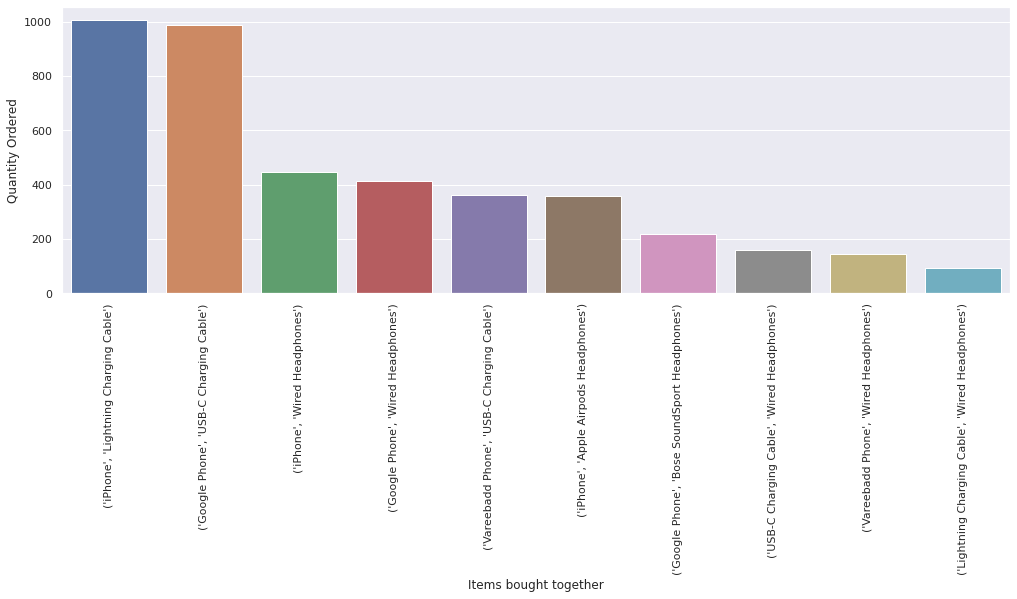

In [184]:
sns.barplot(data=pd.DataFrame(x), x=0, y=1)
plt.xlabel('Items bought together')
plt.ylabel('Quantity Ordered')
b = plt.xticks(rotation=90)

## Conclusions


Our analysis yields the following avenues of investigation:
- December is the best month for sales! It's Christmas season after all. Are goods steeply discounted during Christmas?


- San Francisco is the city with the most sales in the year 2019. Now remember that the items being sold are all electronics. Is San Francisco some kind of electronics hub? Is it because SF is home to the Silicon Valley?


- The best time to advertise would be between 10 AM and 3 PM, during the day, and in the evening between 6 PM and 10 PM. What does this say about the daily habits of people over in the States?


- A sizeable quantity of batteries seem to sell. This is followed by Lightning Charging Cables, USB-C Charging Cables and Wired Headphones. Are Lightning Cables built to break since such a large quantity of it sells compared to the new purchases of iPhones?


- iPhones and Lightning Charging Cables sell the most together. Did Apple release a new model iPhone in 2019 that required the purchase of an additional cable? Which demographic purchases iPhones the most in the USA?